## Notebook for Solar Wind Exploration

In the initial phase, we want to see if we can detect FTEs using unsupervised learning, by finding a manifold for the solar wind data.

The initial hypothesis is the transition matrices (Markov Matrices $M$) that can be derived from Manifolder + clustering will show distinctive clusters and transitions.  We can check accuracy by looking at the label (FTE or not?), and see if this label could have been deduced from the data itself.



In [98]:
# useful set of python includes

%load_ext autoreload
%autoreload 2

import numpy as np

np.set_printoptions(suppress=True, precision=4)

import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg'

import seaborn as sns
sns.set()

import pandas as pd

import time

import random

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load Solar Wind Data, and Run Manifolder

The `dataset_2` file contains 

Dataset-2 (THEMIS):   a list with FTEs periods and non-FTEs periods observed by THEMIS in 2007.  These are combined into one file, randomly FTE - NonFTE - FTE - FTE, NonFTE, etc…

In total there are 63 FTEs and 47 non-FTEs.

The time series are separated by one blank line, and each one has 1440 points in a period of 6 minutes.


In [99]:
import sys
sys.path.append(r"C:\Users\acloninger\GDrive\ac2528Backup\DocsFolder\GitHub\manifolder")
sys.path.append(r"..")

import manifolder as mr
from manifolder import helper as mh


In [100]:
# load the data
# note, you must have started the notebook in the 

print('loading data ...')
df = pd.read_excel('astro_data/dataset_2.xlsx', index_col=0)
df.head()


loading data ...


,bx\t,by\t,bz\t,bl\t,bm\t,bn\t,bmag\t,vx\t,vy\t,vz\t,vmag\t,np,Unnamed: 13,tpar,tper,tp,goal
sc time,,,,,,,,,,,,,,,,,
thd,1.177999e+09,2.06,-4.87,17.77,17.80,4.55,-2.48,18.54,-5.96,2.42,6.94,9.46,0.11,3938.25,3565.04,3689.44,1.0
thd,1.177999e+09,2.01,-4.89,17.69,17.72,4.53,-2.53,18.47,-7.04,1.11,6.79,9.85,0.11,3924.28,3610.40,3715.03,1.0
thd,1.177999e+09,2.01,-4.87,17.71,17.74,4.51,-2.52,18.48,-8.14,-0.21,6.66,10.52,0.11,3910.35,3656.06,3740.82,1.0
thd,1.177999e+09,2.02,-4.80,17.74,17.77,4.47,-2.45,18.48,-9.23,-1.53,6.52,11.40,0.11,3896.40,3701.56,3766.51,1.0
thd,1.177999e+09,1.99,-4.83,17.70,17.73,4.47,-2.50,18.45,-10.26,-2.82,6.37,12.40,0.11,3882.37,3746.46,3791.77,1.0


In [101]:
# convert values from loaded spreadsheet, into a numpy matrices
# note that there is no need for the first value, which is time,
# as it is not part of the manifold
#
# also, note the spreadsheet is missing a column name for `Unnamed: 13`, and the values above
# this have the incorrect column labels; the first relevant vale is bx, which as a magnitude around 2
#
# note the final value of each row is the goal (0 or 1), and not part of z

data_raw = df.values[:, 1:]
print('first line of raw_data:\n', data_raw[0, :])


first line of raw_data:
 [   2.06   -4.87   17.77   17.8     4.55   -2.48   18.54   -5.96    2.42
    6.94    9.46    0.11 3938.25 3565.04 3689.44    1.  ]


In [102]:
import pickle
#Load Data
segments = np.load('themis\segments-newdata-all.npy')

# Load Labels
labels = np.load('themis\labels-newdata-all.npy')
labels = np.asarray(pd.get_dummies(labels))

#Load Bounding Boxes/ Event Locations
with open('themis/bbox.pickle','rb') as f:
    bboxes = pickle.load(f)

In [103]:
# loop through the data, breaking out the clusters
# i will always point to the NaN (blank line) in the dataframe,
# and values [i-1440:i] is the snipped

snippet_len = 1440

# collect all line breaks (blank lines) in csv file
#lineBreaks = [0]
#for i in range(data_raw.shape[0]):
#    if data_raw[i,0] != data_raw[i,0]:  # replacement of isnan, since nan != nan
#        lineBreaks.append(i)    
#lineBreaks.append(data_raw.shape[0])
#
#num_snippet = len(lineBreaks)-1


# callect the snippets into two groups, one for each goal (target) value, 0 or 1
# these can be easily merged
zs_0 = []
zs_1 = []

locallabel_0 = []
locallabel_1 = []
snippet_index = 0;

df.values[0,:]

for i in range(snippet_len,data_raw.shape[0],snippet_len+1):
    # copy the snipped, excluding the last value, which is the goal
    snippet = data_raw[i-snippet_len:i,:-1]

    # grab the goal value from the first row of each snippet
    goal = data_raw[i-snippet_len,-1]
    
    # check to make sure each snippet does not contain NaN
    # (should not, if parsing is correct)
    assert ~np.isnan(snippet).any(), 'oops, snippet contains a Nan!'
    
    print('snippet size',snippet.shape,'with goal',goal)
    
    snippetlabel = np.zeros(snippet_len)
    if goal == 1:
        bmin = int(bboxes[snippet_index][0][0])
        bmax = int(bboxes[snippet_index][0][2])
        snippetlabel[bmin:bmax] = 1
    
    if goal == 0:
        zs_0.append( snippet )
        locallabel_0.append( snippetlabel )
    elif goal == 1:
        zs_1.append( snippet )
        locallabel_1.append( snippetlabel )
    else:
        assert False, 'value of goal not understood'
        
    snippet_index = snippet_index + 1;
        

# shuffle this lists; this should not strictly be necessary, if all the data is being used,
# but prevents biases when shortening the list

c0 = list(zip(zs_0, locallabel_0))
random.shuffle(c0)
zs_0, locallabel_0 = zip(*c0)
zs_0 = list(zs_0)
locallabel_0 = list(locallabel_0)

c1 = list(zip(zs_1, locallabel_1))
random.shuffle(c1)
zs_1, locallabel_1 = zip(*c1)
zs_1 = list(zs_1)
locallabel_1 = list(locallabel_1)

shorten_data = True

if shorten_data:
    zs_0 = zs_0[:20]
    zs_1 = zs_1[:20]
    locallabel_0 = locallabel_0[:20]
    locallabel_1 = locallabel_1[:20]
        
zs = zs_0 + zs_1
locallabel = locallabel_0 + locallabel_1
z_breakpoint = len(zs_0)

print( '\done!')
print( '\t len(zs_0):',len(zs_0))
print( '\t len(zs_1):',len(zs_1))
print( '\t len(zs):',len(zs))


snippet size (1440, 15) with goal 1.0
snippet size (1440, 15) with goal 0.0
snippet size (1440, 15) with goal 1.0
snippet size (1440, 15) with goal 0.0
snippet size (1440, 15) with goal 1.0
snippet size (1440, 15) with goal 1.0
snippet size (1440, 15) with goal 0.0
snippet size (1440, 15) with goal 1.0
snippet size (1440, 15) with goal 0.0
snippet size (1440, 15) with goal 0.0
snippet size (1440, 15) with goal 1.0
snippet size (1440, 15) with goal 0.0
snippet size (1440, 15) with goal 1.0
snippet size (1440, 15) with goal 0.0
snippet size (1440, 15) with goal 1.0
snippet size (1440, 15) with goal 0.0
snippet size (1440, 15) with goal 0.0
snippet size (1440, 15) with goal 0.0
snippet size (1440, 15) with goal 1.0
snippet size (1440, 15) with goal 0.0
snippet size (1440, 15) with goal 0.0
snippet size (1440, 15) with goal 1.0
snippet size (1440, 15) with goal 0.0
snippet size (1440, 15) with goal 1.0
snippet size (1440, 15) with goal 0.0
snippet size (1440, 15) with goal 1.0
snippet size

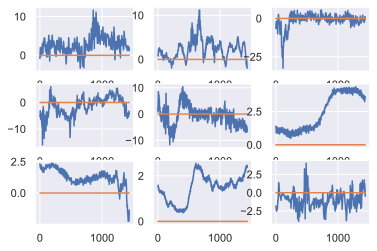

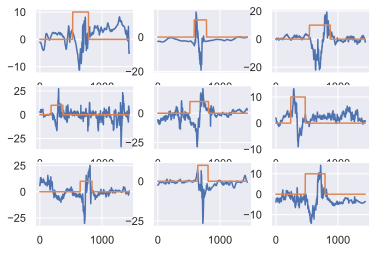

In [104]:
import matplotlib.pyplot as plt

plt.figure()
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.plot(zs_0[i][:,5])
    plt.plot(10*locallabel_0[i])
    
plt.show()

plt.figure()
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.plot(zs_1[i][:,5])
    plt.plot(10*locallabel_1[i])

    
plt.show()

In [105]:
# data has been parsed, now run Manifolder

H = 80
step_size = 10
nbins = 10
ncov = 20

start_time = time.time()

# create manifolder object
manifolder = mr.Manifolder(H=H,step_size=step_size,nbins=nbins, ncov=ncov)

# add the data, and fit (this runs all the functions)
manifolder.fit_transform(zs, parallel=False)

elapsed_time = time.time() - start_time
print('\n\t Program Executed in', str(np.round(elapsed_time, 2)), 'seconds')  # about 215 seconds (four minutes)


calculating histograms for snip  0  of  40  (dim  15  timeseries) ............... done
calculating histograms for snip  1  of  40  (dim  15  timeseries) ............... done
calculating histograms for snip  2  of  40  (dim  15  timeseries) ............... done
calculating histograms for snip  3  of  40  (dim  15  timeseries) ............... done
calculating histograms for snip  4  of  40  (dim  15  timeseries) ............... done
calculating histograms for snip  5  of  40  (dim  15  timeseries) ............... done
calculating histograms for snip  6  of  40  (dim  15  timeseries) ............... done
calculating histograms for snip  7  of  40  (dim  15  timeseries) ............... done
calculating histograms for snip  8  of  40  (dim  15  timeseries) ............... done
calculating histograms for snip  9  of  40  (dim  15  timeseries) ............... done
calculating histograms for snip  10  of  40  (dim  15  timeseries) ............... done
calculating histograms for snip  11  of  4

In [106]:
locallabel_downsample = np.empty(0, float)
for i in range(len(locallabel)):
    x = locallabel[i]
    x = x[0:x.shape[0]-H]
    x = x[::step_size]

    locallabel_downsample = np.append(locallabel_downsample,x,0)
    
Psi = manifolder.Psi[:,0:manifolder.Dim]
    
print(locallabel_downsample.shape)
print(Psi.shape)

(5440,)
(5440, 3)


# Network prediction of locallabel with random train/test splits

In [107]:
import tensorflow as tf
import sklearn

model = tf.keras.Sequential([
    tf.keras.Input(shape=(3,)),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])


# Compile the model
model.compile(loss="sparse_categorical_crossentropy",
              optimizer='adam')


In [108]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(Psi,
                                                    locallabel_downsample,
                                                    test_size=0.33,
                                                    random_state=42)

val_size = .1
val_num = int(val_size*Psi.shape[0])

X_val = X_train[-val_num:]
y_val = y_train[-val_num:]
X_train = X_train[:-val_num]
y_train = y_train[:-val_num]


CM = sklearn.metrics.confusion_matrix(y_train.astype(int), y_train.astype(int))
total = np.sum(CM)
pos = CM[1,1]

class_weight = {0: 1.,
                1: total/pos}

print('Examples in Training:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

CM = sklearn.metrics.confusion_matrix(y_val.astype(int), y_val.astype(int))
total = np.sum(CM)
pos = CM[1,1]

print('Examples in Validation:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

print('Reweighting classes')




Examples in Training:
    Total: 3100
    Positive: 296 (9.55% of total)

Examples in Validation:
    Total: 544
    Positive: 59 (10.85% of total)

Reweighting classes


In [115]:
# Fit data to model
history = model.fit(X_train, y_train,
            batch_size=32,
            epochs=1000,
            class_weight=class_weight,
            validation_data=(X_val, y_val),
            verbose=1)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 3100 samples, validate on 544 samples
Epoch 1/1000
3100/3100 [==============================] - 0s 37us/sample - loss: 0.5034 - val_loss: 0.7774
Epoch 2/1000
3100/3100 [==============================] - 0s 37us/sample - loss: 0.4607 - val_loss: 0.7873
Epoch 3/1000
3100/3100 [==============================] - 0s 36us/sample - loss: 0.4686 - val_loss: 0.6803
Epoch 4/1000
3100/3100 [==============================] - 0s 37us/sample - loss: 0.4763 - val_loss: 0.7925
Epoch 5/1000
3100/3100 [==============================] - 0s 38us/sample - loss: 0.4704 - val_loss: 0.7083
Epoch 6/1000
3100/3100 [==============================] - 0s 36us/sample - loss: 0.4594 - val_loss: 0.6822
Epoch 7/1000
3100/3100 [==============================] - 0s 36us/sample - loss: 0.4695 - val_loss: 0.6954
Epoch 8/1000
3100/3100 [==============================] - 0s 35us/sample - loss: 0.4920 - val_loss: 0.7298
Epoch 9/1000
3100/3100 [=======================

In [116]:
prediction = model.predict(X_test)
predict_class = np.argmax(prediction, axis=1)

CM = sklearn.metrics.confusion_matrix(y_test.astype(int), predict_class )
print(CM)

[[1459  166]
 [   4  167]]


In [117]:
snippet_label = manifolder.snip_number

pred_all = model.predict(Psi)
pred_all_class = np.argmax(pred_all, axis=1)


z_downsample = np.empty((0,zs[0].shape[1]+1), float)
for i in range(len(zs)):
    x = zs[i]
    x = x[0:x.shape[0]-H,:]
    x = x[::step_size]
    if i<z_breakpoint:
        x = np.append(x,np.zeros((x.shape[0],1)),1)
    else:
        x = np.append(x,np.ones((x.shape[0],1)),1)

    z_downsample = np.append(z_downsample,x,0)
    
z_downsample = np.append(z_downsample, manifolder.snip_number.reshape(Psi.shape[0],1), 1)
z_downsample = np.append(z_downsample, pred_all_class.reshape(Psi.shape[0],1), 1)
    
z_downsample.shape

(5440, 18)

In [118]:
np.savetxt('astro_deep_learning_randomSplit.csv', z_downsample, delimiter=',', fmt='%f')

# Network prediction of locallabel with snippet level splits

In [119]:
import tensorflow as tf
import sklearn

model_snippet = tf.keras.Sequential([
    tf.keras.Input(shape=(3,)),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])


# Compile the model
model_snippet.compile(loss="sparse_categorical_crossentropy",
              optimizer='adam')


In [120]:
test_size = .33
val_size = .1

snippet_label = manifolder.snip_number
num_snips_0 = int(len(zs_0))
num_snips_1 = int(len(zs_1))


snip_indices_0 = np.random.permutation(num_snips_0)
snip_indices_1 = np.random.permutation(num_snips_1) + num_snips_0

n_train_0 = int((1-test_size-val_size)*num_snips_0)
n_val_0 = int(val_size*num_snips_0)
snip_train_0 = snip_indices_0[0:n_train_0]
snip_val_0 = snip_indices_0[n_train_0:n_train_0+n_val_0]
snip_test_0 = snip_indices_0[n_train_0+n_val_0: num_snips_0]

n_train_1 = int((1-test_size-val_size)*num_snips_1)
n_val_1 = int(val_size*num_snips_1)
snip_train_1 = snip_indices_1[0:n_train_1]
snip_val_1 = snip_indices_1[n_train_1:n_train_1+n_val_1]
snip_test_1 = snip_indices_1[n_train_1+n_val_1: num_snips_1]


X_train = Psi[np.isin(snippet_label, np.concatenate((snip_train_0, snip_train_1))),:]
y_train = locallabel_downsample[np.isin(snippet_label, np.concatenate((snip_train_0, snip_train_1)))]
X_val = Psi[np.isin(snippet_label, np.concatenate((snip_val_0, snip_val_1))),:]
y_val = locallabel_downsample[np.isin(snippet_label, np.concatenate((snip_val_0, snip_val_1)))]
X_test = Psi[np.isin(snippet_label, np.concatenate((snip_test_0, snip_test_1))),:]
y_test = locallabel_downsample[np.isin(snippet_label, np.concatenate((snip_test_0, snip_test_1)))]


In [121]:
CM = sklearn.metrics.confusion_matrix(y_train.astype(int), y_train.astype(int))
total = np.sum(CM)
pos = CM[1,1]

class_weight = {0: 1.,
                1: total/pos}

print('Examples in Training:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

CM = sklearn.metrics.confusion_matrix(y_val.astype(int), y_val.astype(int))
total = np.sum(CM)
pos = CM[1,1]

print('Examples in Validation:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

print('Reweighting classes')




Examples in Training:
    Total: 2992
    Positive: 283 (9.46% of total)

Examples in Validation:
    Total: 544
    Positive: 58 (10.66% of total)

Reweighting classes


In [127]:
# Fit data to model
history = model_snippet.fit(X_train, y_train,
            batch_size=32,
            epochs=1000,
            class_weight=class_weight,
            validation_data=(X_val, y_val),
            verbose=1)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 2992 samples, validate on 544 samples
Epoch 1/1000
2992/2992 [==============================] - 0s 36us/sample - loss: 0.5423 - val_loss: 1.5182
Epoch 2/1000
2992/2992 [==============================] - 0s 37us/sample - loss: 0.5416 - val_loss: 1.9156
Epoch 3/1000
2992/2992 [==============================] - 0s 35us/sample - loss: 0.5296 - val_loss: 1.5968
Epoch 4/1000
2992/2992 [==============================] - 0s 36us/sample - loss: 0.5327 - val_loss: 1.8829
Epoch 5/1000
2992/2992 [==============================] - 0s 36us/sample - loss: 0.5673 - val_loss: 1.3634
Epoch 6/1000
2992/2992 [==============================] - 0s 36us/sample - loss: 0.6018 - val_loss: 1.4670
Epoch 7/1000
2992/2992 [==============================] - 0s 34us/sample - loss: 0.5475 - val_loss: 1.6805
Epoch 8/1000
2992/2992 [==============================] - 0s 33us/sample - loss: 0.5547 - val_loss: 1.2133
Epoch 9/1000
2992/2992 [=======================

In [128]:
prediction = model_snippet.predict(X_test)
predict_class = np.argmax(prediction, axis=1)

CM = sklearn.metrics.confusion_matrix(y_test.astype(int), predict_class )
print(CM)

[[1463  256]
 [ 102   83]]


In [129]:
pred_all = model_snippet.predict(Psi)
pred_all_class = np.argmax(pred_all, axis=1)


z_downsample = np.empty((0,zs[0].shape[1]+1), float)
for i in range(len(zs)):
    x = zs[i]
    x = x[0:x.shape[0]-H,:]
    x = x[::step_size]
    if i<z_breakpoint:
        x = np.append(x,np.zeros((x.shape[0],1)),1)
    else:
        x = np.append(x,np.ones((x.shape[0],1)),1)

    z_downsample = np.append(z_downsample,x,0)
    
z_downsample = np.append(z_downsample, manifolder.snip_number.reshape(Psi.shape[0],1), 1)
z_downsample = np.append(z_downsample, pred_all_class.reshape(Psi.shape[0],1), 1)
    
z_downsample.shape

(5440, 18)

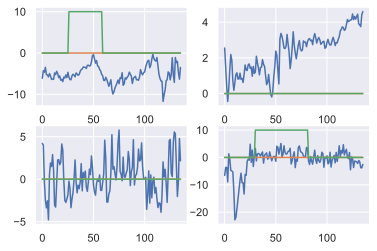

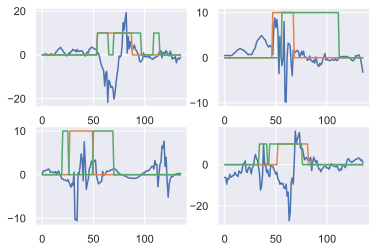

In [130]:
plt.figure()
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.plot(z_downsample[snippet_label==snip_test_0[i]][:,5])
    plt.plot(10*locallabel_downsample[snippet_label==snip_test_0[i]])
    plt.plot(10*pred_all_class[snippet_label==snip_test_0[i]])
    
plt.show()
 
plt.figure()
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.plot(z_downsample[snippet_label==snip_test_1[i]][:,5])
    plt.plot(10*locallabel_downsample[snippet_label==snip_test_1[i]])
    plt.plot(10*pred_all_class[snippet_label==snip_test_1[i]])

    
plt.show()

In [131]:
np.savetxt('astro_deep_learning_snippetSplit.csv', z_downsample, delimiter=',', fmt='%f')